In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Import and Preprocess Datasets

In [27]:
def preprocess_perf_metrics_df(df, dataset_category):
    df['dataset_category'] = dataset_category
    df['model_label'] = df.model.str.split(' ').str[-2]
    df['pretrained'] = 'PRETRAINED'
    df.loc[df.model.str.lower().str.contains('not'), 'pretrained'] = 'NOT PRETRAINED'
    df['model'] = df['model'].str.strip('model').str.strip()
    return df

def preprocess_training_metrics_df(df):
    df['epochs'] = np.tile(list(range(1,11)), (len(df), 1)).tolist()
    metrics_cols = list(df.columns)
    metrics_cols.remove('model_name')
    df = df.explode(metrics_cols)
    metrics_cols = ['model_name'] + metrics_cols
    df = df[metrics_cols]    
    df['dataset_category'] = 'ALL DATA'
    df.loc[df.model_name.str.contains('five shots'), 'dataset_category'] = 'FIVE SHOT'
    df.loc[df.model_name.str.contains('one shot'), 'dataset_category'] = 'ONE SHOT'
    df['pretrained'] = 'PRETRAINED'
    df.loc[df.model_name.str.lower().str.contains('not'), 'pretrained'] = 'NOT PRETRAINED'
    df['model_name_cleaned'] = df.model_name.str.strip('one shot').str.strip('five shots').str.strip('fine-tuned').str.strip(' model').str.strip()
    return df

# Model Performance Metrics
df_fine_tuned = preprocess_perf_metrics_df(pd.read_csv('fine_tuned_metrics.csv'), 'ALL DATA')
df_five_shot = preprocess_perf_metrics_df(pd.read_csv('five_shot_metrics.csv'), 'FIVE SHOT')
df_one_shot = preprocess_perf_metrics_df(pd.read_csv('one_shot_metrics.csv'), 'ONE SHOT')
df_perf_metrics = pd.concat([df_fine_tuned, df_five_shot, df_one_shot])

# Training Metrics
df_train_metrics= preprocess_training_metrics_df(pd.read_json('training_metrics.json'))

In [28]:
CHART_FOLDER = 'metrics_visualization'

### Fine Tuned Train/Test Acc by Shots

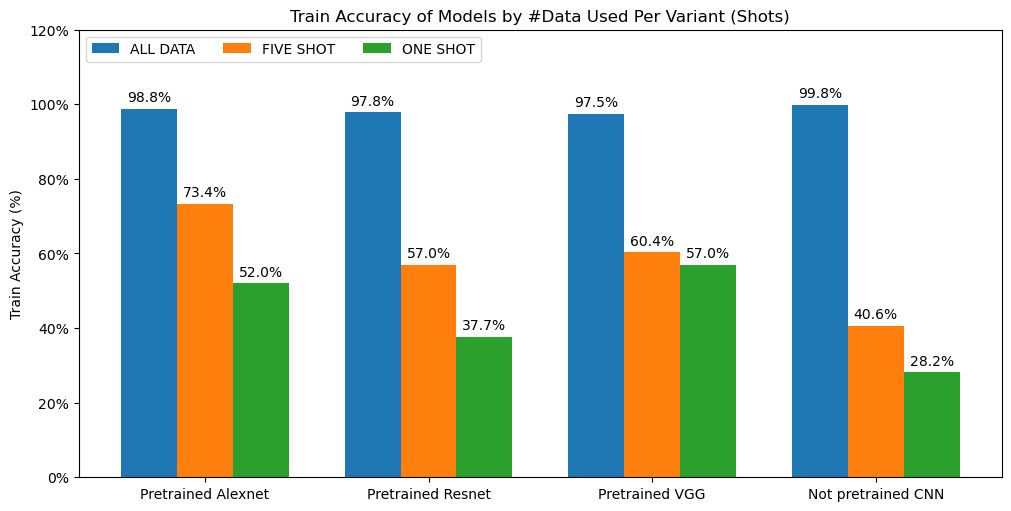

In [29]:
# Code reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
import matplotlib.ticker as mtick
train_acc_data = df_perf_metrics.loc[(df_perf_metrics.pretrained=='PRETRAINED') | (df_perf_metrics.model_label=='CNN'), ['dataset_category', 'model', 'train_acc']]
models = train_acc_data.model.unique().tolist()
train_acc_vals = train_acc_data[['dataset_category', 'train_acc']]
train_acc_vals['train_acc'] = train_acc_vals['train_acc'].apply(lambda x: [x])
train_acc_dict = {key: acc_vals['train_acc'] for key, acc_vals in train_acc_vals.groupby('dataset_category').sum().to_dict('index').items()}
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Format y-axis as a percentage
for attribute, measurement in train_acc_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='{:.1%}')
    multiplier += 1
ax.set_ylabel('Train Accuracy (%)')
CHART_TITLE = 'Train Accuracy of Models by #Data Used Per Variant (Shots)'
ax.set_title(CHART_TITLE)
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)
plt.savefig(CHART_FOLDER + '/' + CHART_TITLE + '.png')

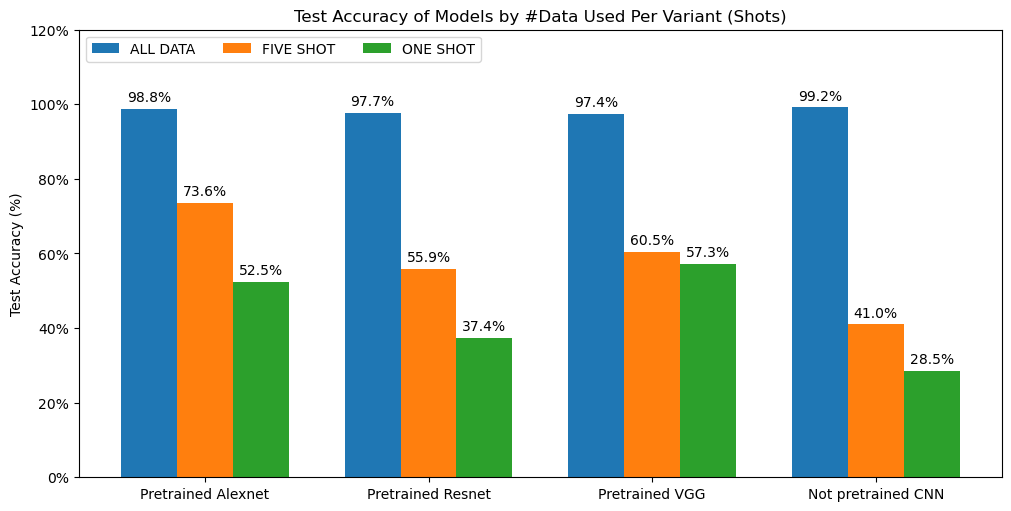

In [30]:
# Code reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
import matplotlib.ticker as mtick
test_acc_data = df_perf_metrics.loc[(df_perf_metrics.pretrained=='PRETRAINED') | (df_perf_metrics.model_label=='CNN'), ['dataset_category', 'model', 'test_acc']]
models = test_acc_data.model.unique().tolist()
test_acc_vals = test_acc_data[['dataset_category', 'test_acc']]
test_acc_vals['test_acc'] = test_acc_vals['test_acc'].apply(lambda x: [x])
test_acc_dict = {key: acc_vals['test_acc'] for key, acc_vals in test_acc_vals.groupby('dataset_category').sum().to_dict('index').items()}
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Format y-axis as a percentage
for attribute, measurement in test_acc_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='{:.1%}')
    multiplier += 1
ax.set_ylabel('Test Accuracy (%)')
CHART_TITLE = 'Test Accuracy of Models by #Data Used Per Variant (Shots)' 
ax.set_title(CHART_TITLE)
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)
plt.savefig(CHART_FOLDER + '/' + CHART_TITLE + '.png')

### Fine Tuned Train/Val Acc by #Epochs (All Data)

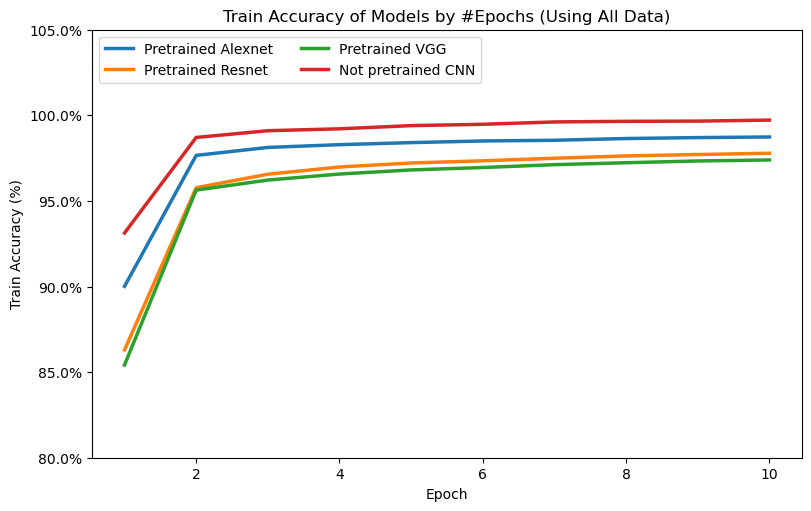

In [31]:
df_traindata_lin = df_train_metrics.loc[(df_train_metrics.dataset_category=='ALL DATA') & ((df_train_metrics.pretrained=='PRETRAINED') | (df_train_metrics.model_name_cleaned.str.contains('CNN'))), ['model_name_cleaned', 'epochs', 'train_acc']]
fig, ax = plt.subplots(layout='constrained', figsize=(8, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Format y-axis as a percentage
for model in df_traindata_lin.model_name_cleaned.unique():
    curr_data_to_plot = df_traindata_lin[df_traindata_lin.model_name_cleaned==model]
    ax.plot(curr_data_to_plot.epochs, curr_data_to_plot.train_acc, label=model, linewidth='2.5')
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0.8, 1.05)
ax.set_ylabel('Train Accuracy (%)')
ax.set_xlabel('Epoch')
CHART_TITLE = 'Train Accuracy of Models by #Epochs (Using All Data)'
ax.set_title(CHART_TITLE)
plt.savefig(CHART_FOLDER + '/' + CHART_TITLE + '.png')

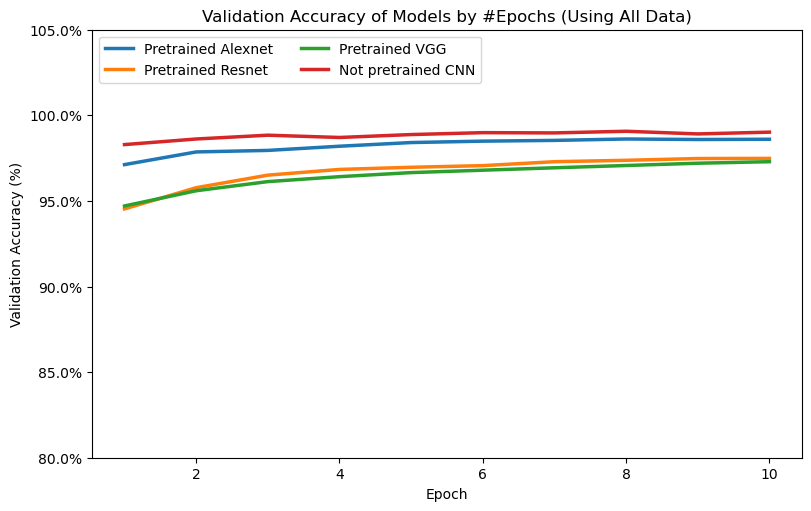

In [32]:
df_valdata_lin = df_train_metrics.loc[(df_train_metrics.dataset_category=='ALL DATA') & ((df_train_metrics.pretrained=='PRETRAINED') | (df_train_metrics.model_name_cleaned.str.contains('CNN'))), ['model_name_cleaned', 'epochs', 'val_acc']]
fig, ax = plt.subplots(layout='constrained', figsize=(8, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Format y-axis as a percentage
for model in df_valdata_lin.model_name_cleaned.unique():
    curr_data_to_plot = df_valdata_lin[df_valdata_lin.model_name_cleaned==model]
    ax.plot(curr_data_to_plot.epochs, curr_data_to_plot.val_acc, label=model, linewidth='2.5')
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0.8, 1.05)
ax.set_ylabel('Validation Accuracy (%)')
ax.set_xlabel('Epoch')
CHART_TITLE = 'Validation Accuracy of Models by #Epochs (Using All Data)'
ax.set_title(CHART_TITLE)
plt.savefig(CHART_FOLDER + '/' + CHART_TITLE + '.png')

In [39]:
df_train_metrics.model_name.unique()

array(['Not pretrained Alexnet model one shot',
       'Not pretrained Resnet model one shot',
       'Not pretrained VGG model one shot',
       'Pretrained Alexnet model one shot',
       'Pretrained Resnet model one shot',
       'Pretrained VGG model one shot',
       'Not pretrained CNN model one shot',
       'Not pretrained Alexnet model five shots',
       'Not pretrained Resnet model five shots',
       'Not pretrained VGG model five shots',
       'Pretrained Alexnet model five shots',
       'Pretrained Resnet model five shots',
       'Pretrained VGG model five shots',
       'Not pretrained CNN model five shots',
       'Not pretrained Alexnet model fine-tuned',
       'Not pretrained Resnet model fine-tuned',
       'Not pretrained VGG model fine-tuned',
       'Pretrained Alexnet model fine-tuned',
       'Pretrained Resnet model fine-tuned',
       'Pretrained VGG model fine-tuned',
       'Not pretrained CNN model fine-tuned'], dtype=object)

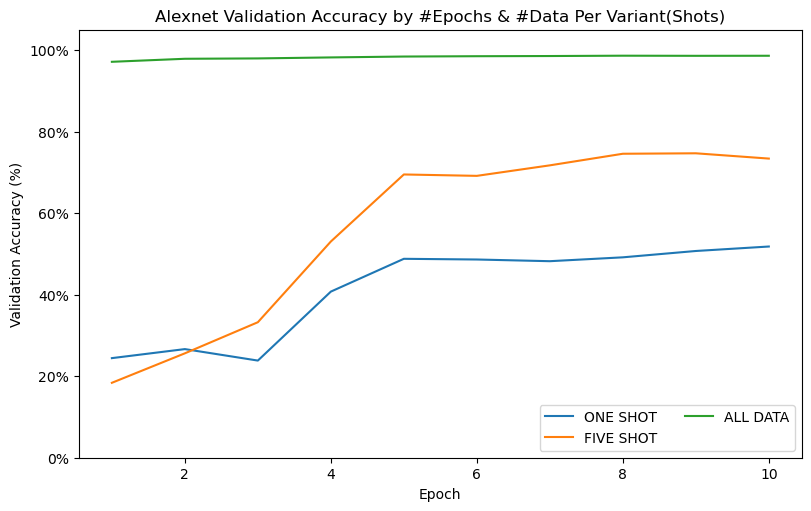

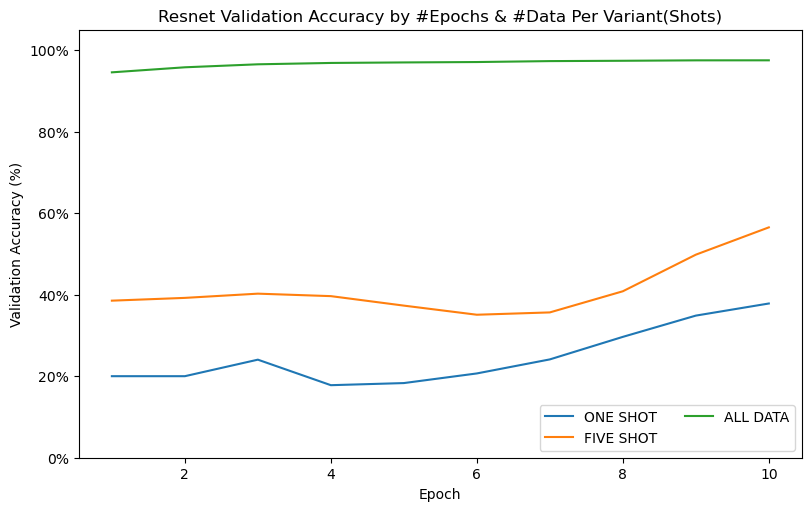

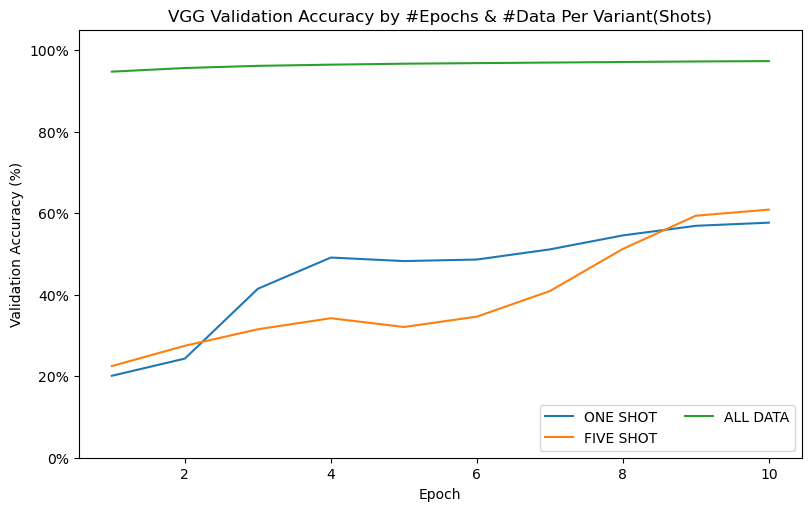

In [40]:
models = ['Alexnet', 'Resnet', 'VGG']
for model in models:
    df_traindata_lin= df_train_metrics.loc[
                                            (df_train_metrics.pretrained=='PRETRAINED') & (df_train_metrics.model_name_cleaned.str.contains(model))
                                        ,['dataset_category', 'epochs', 'val_acc']
                                        ]
    fig, ax = plt.subplots(layout='constrained', figsize=(8, 5))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Format y-axis as a percentage
    for curr_dataset_category in df_traindata_lin.dataset_category.unique():
        curr_data_to_plot = df_traindata_lin[df_traindata_lin.dataset_category==curr_dataset_category]
        ax.plot(curr_data_to_plot.epochs, curr_data_to_plot.val_acc, label=curr_dataset_category)
    ax.legend(loc='lower right', ncols=2)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('Validation Accuracy (%)')
    ax.set_xlabel('Epoch')
    CHART_TITLE = f'{model} Validation Accuracy by #Epochs & #Data Per Variant(Shots)'
    ax.set_title(CHART_TITLE)
    plt.savefig(CHART_FOLDER + '/' + CHART_TITLE + '.png')

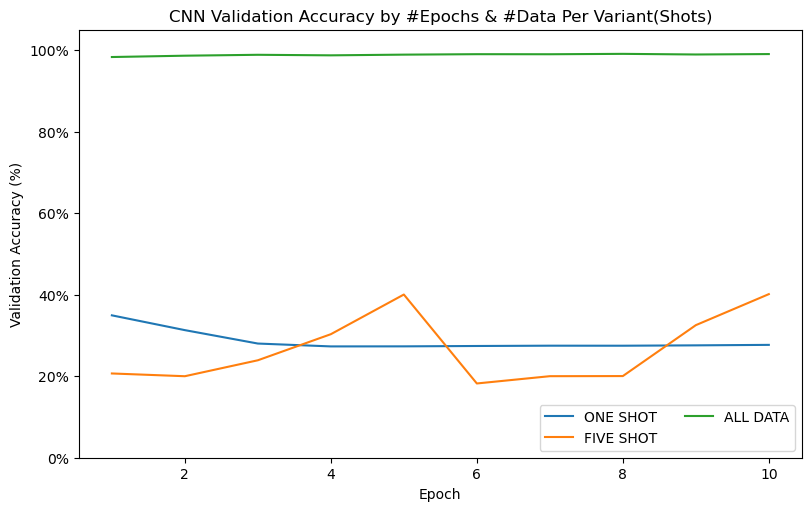

In [41]:
models = ['CNN']
for model in models:
    df_traindata_lin= df_train_metrics.loc[
                                            (df_train_metrics.model_name_cleaned.str.contains(model))
                                        ,['dataset_category', 'epochs', 'val_acc']
                                        ]
    fig, ax = plt.subplots(layout='constrained', figsize=(8, 5))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Format y-axis as a percentage
    for curr_dataset_category in df_traindata_lin.dataset_category.unique():
        curr_data_to_plot = df_traindata_lin[df_traindata_lin.dataset_category==curr_dataset_category]
        ax.plot(curr_data_to_plot.epochs, curr_data_to_plot.val_acc, label=curr_dataset_category)
    ax.legend(loc='lower right', ncols=2)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('Validation Accuracy (%)')
    ax.set_xlabel('Epoch')
    CHART_TITLE = f'{model} Validation Accuracy by #Epochs & #Data Per Variant(Shots)'
    ax.set_title(CHART_TITLE)
    plt.savefig(CHART_FOLDER + '/' + CHART_TITLE + '.png')